# Integrated Gradient 

Integrated gradient is a model-specific XAI method. Indeed, it requires a **gradient**.
Let's first create and train a model
  

## Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Data import 

Let's us MNIST data set. To make our example even more clearer, we will classify only between 1 and 7. Usually the hardest to identify due to there similarity in script wrtting. 

In [18]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch

class SubsetMNIST(Dataset):
    def __init__(self, original_dataset, classes=[1, 7]):
        self.data = []
        self.targets = []
        
        # Define the transformation to convert images to tensors
        transform = transforms.Compose([transforms.ToTensor()])
        
        # Filter dataset to only include the classes you want
        for i in range(len(original_dataset)):
            img, label = original_dataset[i]
            if label in classes:
                # Apply the transformation to the image
                img = transform(img)
                
                # Remap labels: 1 -> 0, 7 -> 1
                if label == 1:
                    label = 0
                elif label == 7:
                    label = 1
                
                self.data.append(img)
                self.targets.append(label)
        
        # Convert the list of targets to a tensor
        self.targets = torch.tensor(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)

# Load the original MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True)
full_test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# Create a subset of the MNIST dataset containing only classes 1 and 7
train_dataset = SubsetMNIST(full_train_dataset, classes=[1, 7])
test_dataset = SubsetMNIST(full_test_dataset, classes=[1, 7])


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


## Model :

Let's now build our simple CNN model

In [ ]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.pool = nn.AvgPool2d(2, 2)  # 28x28 -> 14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 2)  # 32 channels * 14x14 spatial size -> 2 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)  # Pooling to reduce the size
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc1(x)
        return x


### Training 
Let's train it for a few epochs :

In [9]:
# Initialize the model, criterion, and optimizer
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Set number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [1/5], Loss: 0.0613
Epoch [2/5], Loss: 0.0160
Epoch [3/5], Loss: 0.0121
Epoch [4/5], Loss: 0.0106
Epoch [5/5], Loss: 0.0082
Training complete!


In [10]:
correct = 0
total = 0
with torch.no_grad():  # No gradients needed for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 99.77%


### Evaluation : 

Finally let's evaluate to check the robustness of our model

torch.Size([5, 1, 28, 28])


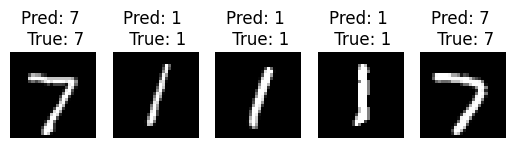

Accuracy on test set: 99.77%


In [ ]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

# Get a batch of test data
images, labels = next(iter(test_loader))  # Get a batch of images
outputs = model(images)
print(images.shape)
# Get predicted class indices
_, predicted = torch.max(outputs, 1)

# Plot the first 5 images in the batch with their predicted and true labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")  # squeeze to remove unnecessary dimension
    plt.title(f"Pred: {(predicted[i].item())*6+1} \n True: {(labels[i].item())*6+1}")
    plt.axis('off')

plt.show()

# Compute accuracy on the test dataset
correct = 0
total = 0
with torch.no_grad():  # No need to track gradients for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100  # Accuracy as percentage
print(f"Accuracy on test set: {accuracy:.2f}%")



## Integrated gradient 

Integrated gradient quantifies the contribution of each input feature to a model's prediction.

It has been built to resepect two desirable properties : 
- **Sensitivity**: ensures non-zero attributions for features that affect the prediction.
- **Implementation invariance**: guaranty consistent attributions for functionally equivalent models.

**IG consider the contribution of the $i-th$ dimension (or feature) to be the gradient at all points along the line segment in ${\rm I\!R}$ connecting $x$ to $x'$.**


\begin{equation}
  IG_i(x) = (x_i -x'_i)*\int_{\alpha=0}^{1}\dfrac{\delta F(x'+\alpha*(x-x'))} {\delta x_i} d\alpha
\end{equation}

Where $x'$ is a chosen reference, that approximate a null contribution, (e.g. a black pixel or gaussian noise).

$x'+\alpha*(x-x'))$ controls how close we are getting from $x$. With $\alpha$ close to $0$, we are very close to $x'$.

$(x_i -x'_i)$ is used to weight the contribution. The further the evaluated feature is from the reference, the *longest* is the path and so the higher the contribution is supposed to be. 



In practice, we approximate this gradient by summing up the contribution taking steps from $x$ to $x'$

\begin{equation}
  IG_i(x) = (x_i -x'_i)*\sum_{k=1}^{m}\dfrac{\delta F(x'+\dfrac{k}{m}*(x-x'))} {\delta x_i} \dfrac{1}{m}
\end{equation}




In [62]:


def integrated_gradients(model, x, baseline, target_class, steps=50):
    """
    Computes Integrated Gradients for an image `x` w.r.t. `target_class`.
    
    Args:
        model: The trained CNN model.
        x: The input image tensor (1, 1, 28, 28).
        baseline: The baseline image.
        target_class: The class index for IG computation.
        steps: Number of steps for IG approximation.

    Returns:
        IG attributions as a heatmap.
    """
    # Generate interpolated images
    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1)  # Use linear space
    interpolated_inputs = baseline + alphas * (x - baseline)

    # Store gradients
    gradients = torch.zeros_like(x)


    fig, axes = plt.subplots(1, (steps // 10)+2, figsize=(steps // 10 * 2, 2))
    plot_idx = 0

    # Loop over interpolated images and compute gradients
    for i in range(steps):
        interpolated_input = interpolated_inputs[i].unsqueeze(0).requires_grad_()

        if i % 10 == 0:
            # Show current interpolation step
            img = interpolated_input.squeeze().detach().cpu().numpy()
            axes[plot_idx].imshow(img, cmap="gray", vmin=0, vmax=1)
            axes[plot_idx].set_title(f"Step {i+1}/{steps}")
            axes[plot_idx].axis("off")
            plot_idx += 1 

        output = model(interpolated_input)  # Add batch dim
        target_output = output[0, target_class]  # Get target class score

        # Backward pass
        model.zero_grad()  # Clear gradients from previous step
        target_output.backward(retain_graph=True)  # Retain the graph for multiple backward passes

        # Accumulate gradients
        gradients += interpolated_input.grad.detach()
       

    axes[plot_idx].imshow(x.squeeze(), cmap="gray", vmin=0, vmax=1)
    axes[plot_idx].set_title(f"Raw image")
    axes[plot_idx].axis("off")
    plot_idx += 1 

    

    # Average gradients over steps
    avg_gradients = gradients / steps
    integrated_grads = (x - baseline) * avg_gradients
    
    axes[plot_idx].imshow(integrated_grads.squeeze(), cmap="hot", vmin=0, vmax=1)
    axes[plot_idx].set_title(f"IG")
    axes[plot_idx].axis("off")
    plot_idx += 1
    return integrated_grads



1


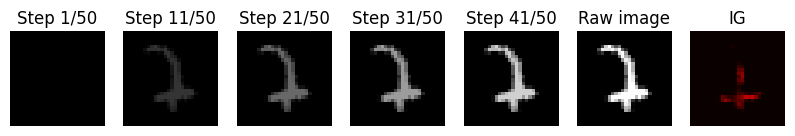

In [67]:
test_image, test_label = test_dataset[278]  # Image wrongly classified

test_image = test_image.unsqueeze(0) 

# Define a zero baseline (black image)
baseline = torch.zeros_like(test_image)

# Get the predicted class for our test image
output = model(test_image)
predicted_class = output.argmax().item()
print(predicted_class*6+1)
# Compute Integrated Gradients
ig_attributions = integrated_gradients(model, test_image, baseline, target_class=predicted_class, steps=50)

1


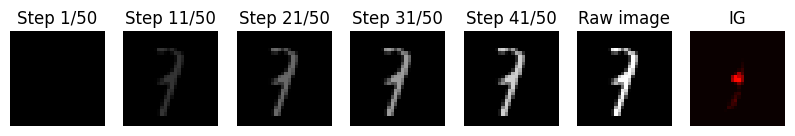

In [66]:
test_image, test_label = test_dataset[329]  # Image wrongly classified

test_image = test_image.unsqueeze(0) 

# Define a zero baseline (black image)
baseline = torch.zeros_like(test_image)

# Get the predicted class for our test image
output = model(test_image)
predicted_class = output.argmax().item()
print(predicted_class*6+1)
# Compute Integrated Gradients
ig_attributions = integrated_gradients(model, test_image, baseline, target_class=predicted_class, steps=50) # Add batch dimension

Remark : 

- In this example we are using grayscale, so we are only computing the gradient of each pixel on one dimension. In case the input is several dimension, the 

- One sanity test to run is to test to check the completeness. The completness property is imply by the sensitivity $\sum_{i=1}^{n}IntegratedGrads(x)=F(x) - F(x')$